In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine Learning libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb

# Set visualization style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Load Preprocessed Data


In [3]:
# Load preprocessed data
data_path = '../data/processed_data/'



# Load training and test sets
X_train = pd.read_csv(data_path + 'X_train_scaled.csv', index_col=0)
X_test = pd.read_csv(data_path + 'X_test_scaled.csv', index_col=0)
y_train = pd.read_csv(data_path + 'y_train.csv', index_col=0)['Appliances']
y_test = pd.read_csv(data_path + 'y_test.csv', index_col=0)['Appliances']


## 2. define Evaluation Metrics


In [4]:
def evaluate_model(y_true, y_pred, model_name):
  
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    
    results = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE_percent': mape
    }
    
    return results

def plot_predictions(y_true, y_pred, model_name, dataset='Test'):
 
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot: Predicted vs Actual
    axes[0].scatter(y_true, y_pred, alpha=0.6, s=20)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    axes[0].set_xlabel('Actual Energy (Wh)')
    axes[0].set_ylabel('Predicted Energy (Wh)')
    axes[0].set_title(f'{model_name} - {dataset} Set\nPredicted vs Actual')
    axes[0].grid(True, alpha=0.3)
    
    # Calculate and display metrics on plot
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    axes[0].text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.2f}', 
                transform=axes[0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Residual plot
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, s=20)
    axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Predicted Energy (Wh)')
    axes[1].set_ylabel('Residuals (Actual - Predicted)')
    axes[1].set_title(f'{model_name} - Residual Plot')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



## 3. Baseline Model 1: Linear Regression

**Assumptions:** Linear relationship between features and target
**Purpose:** Establish the simplest possible baseline

In [5]:
# Initialize and train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate on both training and test sets
lr_train_results = evaluate_model(y_train, y_train_pred_lr, 'Linear Regression (Train)')
lr_test_results = evaluate_model(y_test, y_test_pred_lr, 'Linear Regression (Test)')

# Display results
print(f"Training Performance:")
for key, value in lr_train_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

print(f"\nTest Performance:")
for key, value in lr_test_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

# Check for overfitting
train_r2 = lr_train_results['R²']
test_r2 = lr_test_results['R²']
overfitting_gap = train_r2 - test_r2

print(f"\nOverfitting Analysis:")
print(f"   Training R²: {train_r2:.4f}")
print(f"   Test R²: {test_r2:.4f}")
print(f"   Gap: {overfitting_gap:.4f}")
if overfitting_gap < 0.05:
    print("   Status: No significant overfitting")
elif overfitting_gap < 0.1:
    print("   Status: Mild overfitting")
else:
    print("   Status: Significant overfitting")

# Cross-validation
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='r2')
print(f"\n5-Fold Cross-Validation R²: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")

Training Performance:
   MSE: 3234.2360
   RMSE: 56.8703
   MAE: 28.9507
   R²: 0.7110
   MAPE_percent: 28.8447

Test Performance:
   MSE: 2824.0216
   RMSE: 53.1415
   MAE: 28.4155
   R²: 0.6339
   MAPE_percent: 28.4212

Overfitting Analysis:
   Training R²: 0.7110
   Test R²: 0.6339
   Gap: 0.0771
   Status: Mild overfitting

5-Fold Cross-Validation R²: 0.7002 (±0.0291)


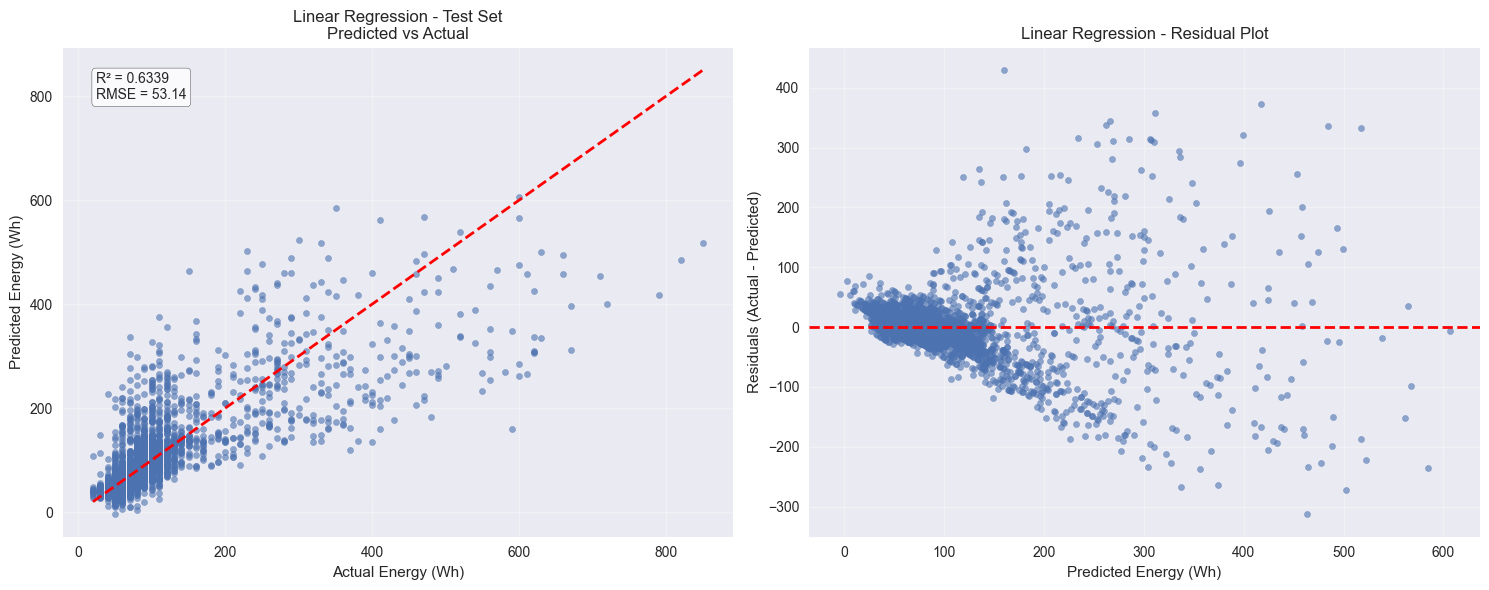

In [6]:
# Visualize Linear Regression performance
plot_predictions(y_test, y_test_pred_lr, 'Linear Regression', 'Test')

## 4. Baseline Model 2: Ridge Regression (Regularized)

**Purpose:** Handle multicollinearity and prevent overfitting with L2 regularization

In [7]:


# Hyperparameter tuning for Ridge
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2', n_jobs=-1)
ridge_grid.fit(X_train, y_train)

# Best Ridge model
best_ridge = ridge_grid.best_estimator_
print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best CV R²: {ridge_grid.best_score_:.4f}")

# Predictions
y_train_pred_ridge = best_ridge.predict(X_train)
y_test_pred_ridge = best_ridge.predict(X_test)

# Evaluate
ridge_train_results = evaluate_model(y_train, y_train_pred_ridge, 'Ridge Regression (Train)')
ridge_test_results = evaluate_model(y_test, y_test_pred_ridge, 'Ridge Regression (Test)')

print(f"\nTraining Performance:")
for key, value in ridge_train_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

print(f"\nTest Performance:")
for key, value in ridge_test_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

# Overfitting analysis
train_r2 = ridge_train_results['R²']
test_r2 = ridge_test_results['R²']
overfitting_gap = train_r2 - test_r2
print(f"\nOverfitting Gap: {overfitting_gap:.4f} (smaller = better regularization)")

Best Ridge alpha: 100.0
Best CV R²: 0.7009

Training Performance:
   MSE: 3238.4654
   RMSE: 56.9075
   MAE: 28.8752
   R²: 0.7106
   MAPE_percent: 28.6936

Test Performance:
   MSE: 2738.4450
   RMSE: 52.3302
   MAE: 26.8333
   R²: 0.6450
   MAPE_percent: 26.0695

Overfitting Gap: 0.0656 (smaller = better regularization)


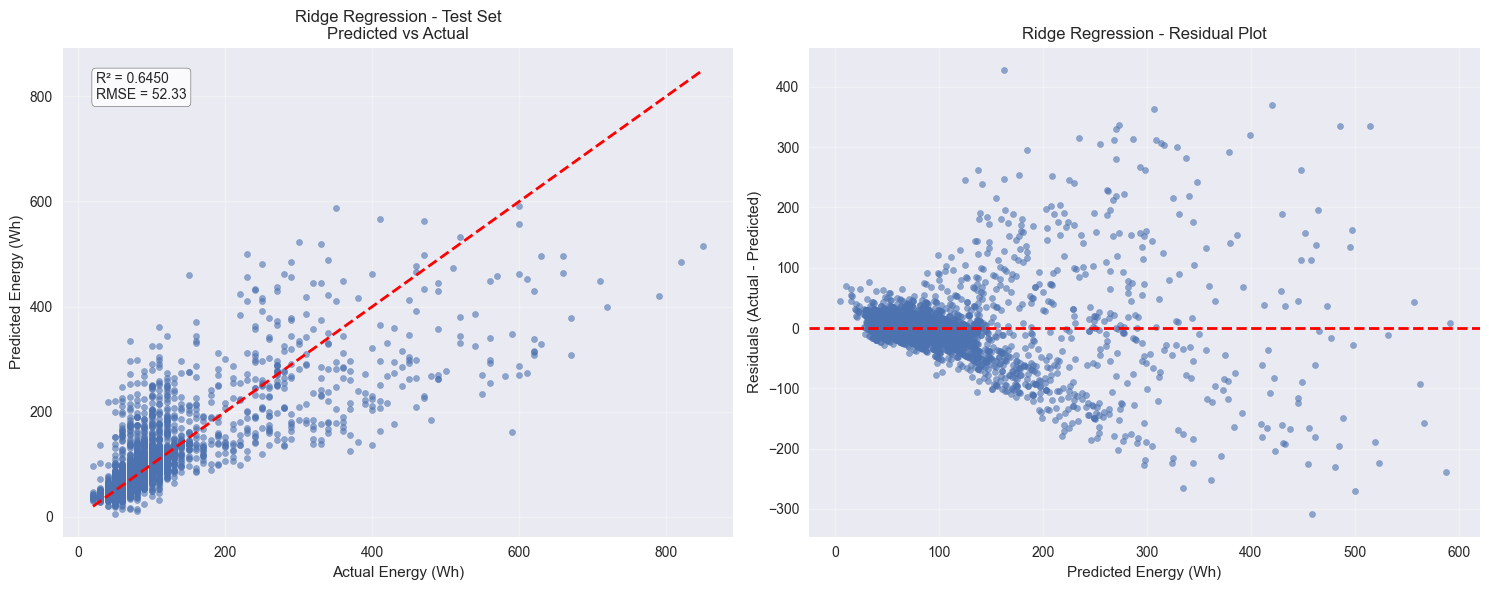

In [8]:
# Visualize Ridge Regression performance
plot_predictions(y_test, y_test_pred_ridge, 'Ridge Regression', 'Test')

## 5. Baseline Model 3: Random Forest

**Purpose:** Capture non-linear relationships and feature interactions

In [9]:

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200], #numbe rof decision trees in the forest
    'max_depth': [10, 15, 20, None],#maximum depth each tree can grow
    'min_samples_split': [2, 5],#minimum samples required to split a node
    'min_samples_leaf': [1, 2],#minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2']#number of features to consider at each split
}


rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                       rf_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Best Random Forest model
best_rf = rf_grid.best_estimator_
print(f"\nBest Random Forest parameters: {rf_grid.best_params_}")
print(f"Best CV R²: {rf_grid.best_score_:.4f}")

# Predictions
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

# Evaluate
rf_train_results = evaluate_model(y_train, y_train_pred_rf, 'Random Forest (Train)')
rf_test_results = evaluate_model(y_test, y_test_pred_rf, 'Random Forest (Test)')

print(f"\nTraining Performance:")
for key, value in rf_train_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

print(f"\nTest Performance:")
for key, value in rf_test_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

# Overfitting analysis
train_r2 = rf_train_results['R²']
test_r2 = rf_test_results['R²']
overfitting_gap = train_r2 - test_r2
print(f"\nOverfitting Gap: {overfitting_gap:.4f}")

if overfitting_gap > 0.1:
    print("Random Forest shows signs of overfitting")
else:
    print("Random Forest overfitting is within acceptable range")

Fitting 3 folds for each of 64 candidates, totalling 192 fits

Best Random Forest parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best CV R²: 0.6990

Training Performance:
   MSE: 734.4369
   RMSE: 27.1005
   MAE: 12.7653
   R²: 0.9344
   MAPE_percent: 12.2675

Test Performance:
   MSE: 3038.9037
   RMSE: 55.1263
   MAE: 30.0797
   R²: 0.6060
   MAPE_percent: 31.2327

Overfitting Gap: 0.3283
Random Forest shows signs of overfitting


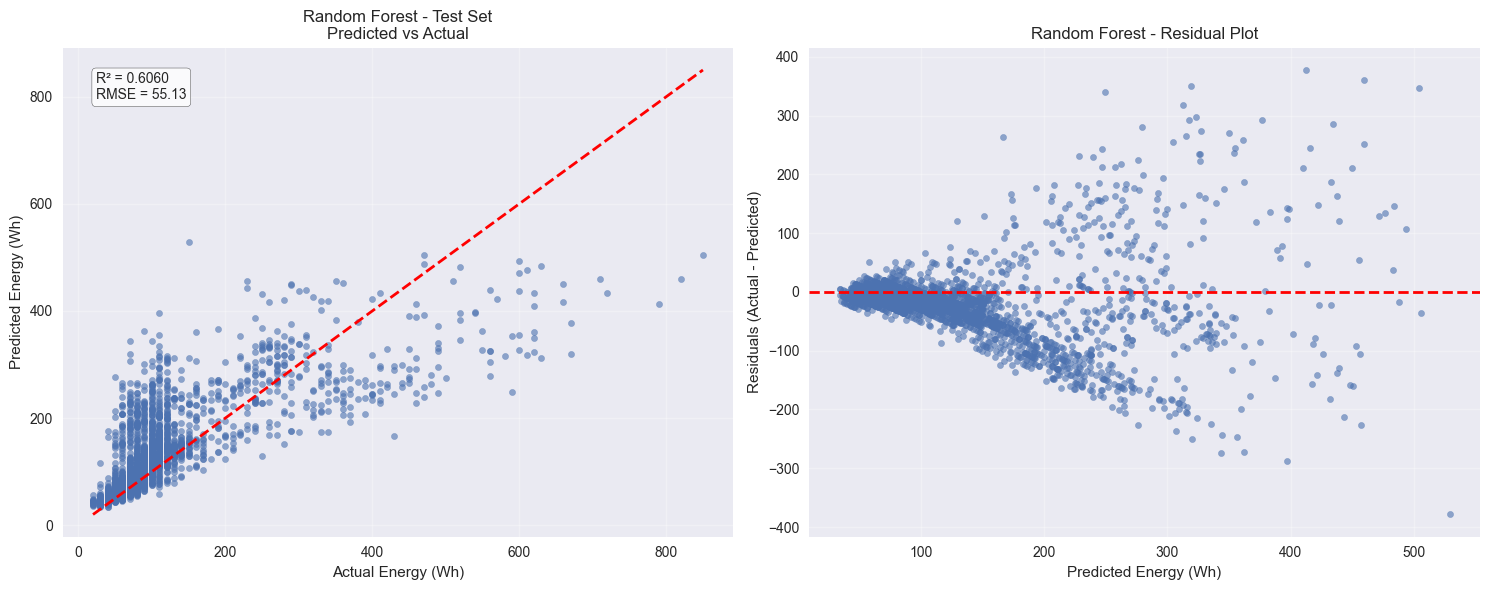

In [ ]:
# Visualize Random Forest performance
plot_predictions(y_test, y_test_pred_rf, 'Random Forest', 'Test')

## 6. Baseline Model 4: XGBoost (Advanced Baseline)

**Purpose:** State-of-the-art gradient boosting for maximum baseline performance

In [11]:

# XGBoost hyperparameter tuning
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0] #random fraction of features to consider at each tree
}


xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    xgb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1
)
xgb_grid.fit(X_train, y_train)

# Best XGBoost model
best_xgb = xgb_grid.best_estimator_
print(f"\nBest XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best CV R²: {xgb_grid.best_score_:.4f}")

# Predictions
y_train_pred_xgb = best_xgb.predict(X_train)
y_test_pred_xgb = best_xgb.predict(X_test)

# Evaluate
xgb_train_results = evaluate_model(y_train, y_train_pred_xgb, 'XGBoost (Train)')
xgb_test_results = evaluate_model(y_test, y_test_pred_xgb, 'XGBoost (Test)')

print(f"\nTraining Performance:")
for key, value in xgb_train_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

print(f"\nTest Performance:")
for key, value in xgb_test_results.items():
    if key != 'Model':
        print(f"   {key}: {value:.4f}")

# Overfitting analysis
train_r2 = xgb_train_results['R²']
test_r2 = xgb_test_results['R²']
overfitting_gap = train_r2 - test_r2
print(f"\nOverfitting Gap: {overfitting_gap:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
Best CV R²: 0.7668

Training Performance:
   MSE: 727.5726
   RMSE: 26.9736
   MAE: 14.7859
   R²: 0.9350
   MAPE_percent: 17.1554

Test Performance:
   MSE: 2642.6802
   RMSE: 51.4070
   MAE: 25.1828
   R²: 0.6574
   MAPE_percent: 25.3235

Overfitting Gap: 0.2776


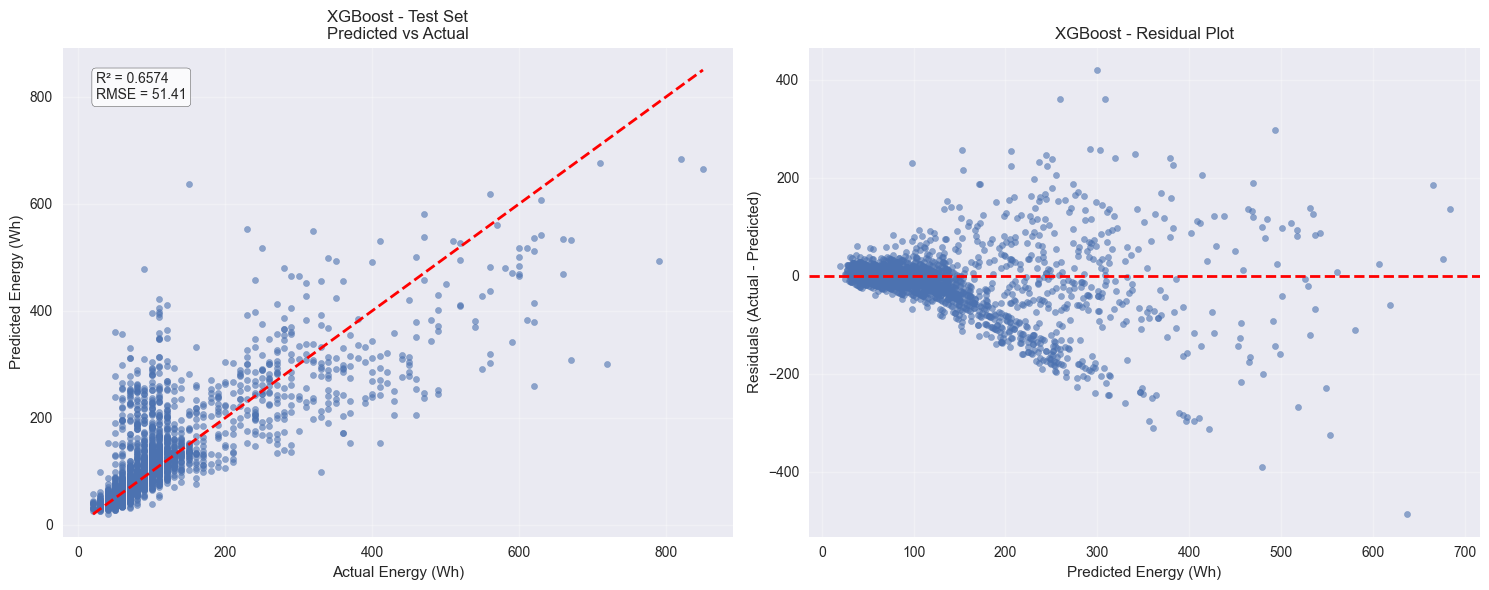

In [12]:
# Visualize XGBoost performance
plot_predictions(y_test, y_test_pred_xgb, 'XGBoost', 'Test')

## 7. Model Comparison and Analysis

Compare all baseline models to identify the best performer and establish benchmarks for deep learning.

In [13]:
# Compile all results
all_results = [
    lr_test_results,
    ridge_test_results,
    rf_test_results,
    xgb_test_results
]

results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)


print(results_df.to_string(index=False))

# Find best model for each metric
best_models = {}
for metric in ['R²', 'RMSE', 'MAE']:
    if metric in ['RMSE', 'MAE', 'MAPE_percent']:  # Lower is better
        best_idx = results_df[metric].idxmin()
    else:  # Higher is better
        best_idx = results_df[metric].idxmax()
    best_models[metric] = results_df.loc[best_idx, 'Model']

print(f"\nperformance:")
for metric, model in best_models.items():
    value = results_df.loc[results_df['Model'] == model, metric].values[0]
    print(f"   {metric:<15}: {model:<25} ({value:.4f})")

# Overall best model (based on R² score)
best_overall = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_r2 = results_df['R²'].max()
print(f"\nbetter model: {best_overall} (R² = {best_r2:.4f})")

# Set benchmark for deep learning models
benchmark_rmse = results_df['RMSE'].min()
benchmark_r2 = results_df['R²'].max()

print(f"\n Benchmark for deep learning models")
print(f"   Target R² : {benchmark_r2:.4f}")
print(f"   Target RMSE : {benchmark_rmse:.2f} Wh")
print(f"   Deep learning success criteria: R² > {benchmark_r2:.4f} AND RMSE < {benchmark_rmse:.2f}")

                   Model       MSE    RMSE     MAE     R²  MAPE_percent
Linear Regression (Test) 2824.0216 53.1415 28.4155 0.6339       28.4212
 Ridge Regression (Test) 2738.4450 52.3302 26.8333 0.6450       26.0695
    Random Forest (Test) 3038.9037 55.1263 30.0797 0.6060       31.2327
          XGBoost (Test) 2642.6802 51.4070 25.1828 0.6574       25.3235

performance:
   R²             : XGBoost (Test)            (0.6574)
   RMSE           : XGBoost (Test)            (51.4070)
   MAE            : XGBoost (Test)            (25.1828)

better model: XGBoost (Test) (R² = 0.6574)

 Benchmark for deep learning models
   Target R² : 0.6574
   Target RMSE : 51.41 Wh
   Deep learning success criteria: R² > 0.6574 AND RMSE < 51.41


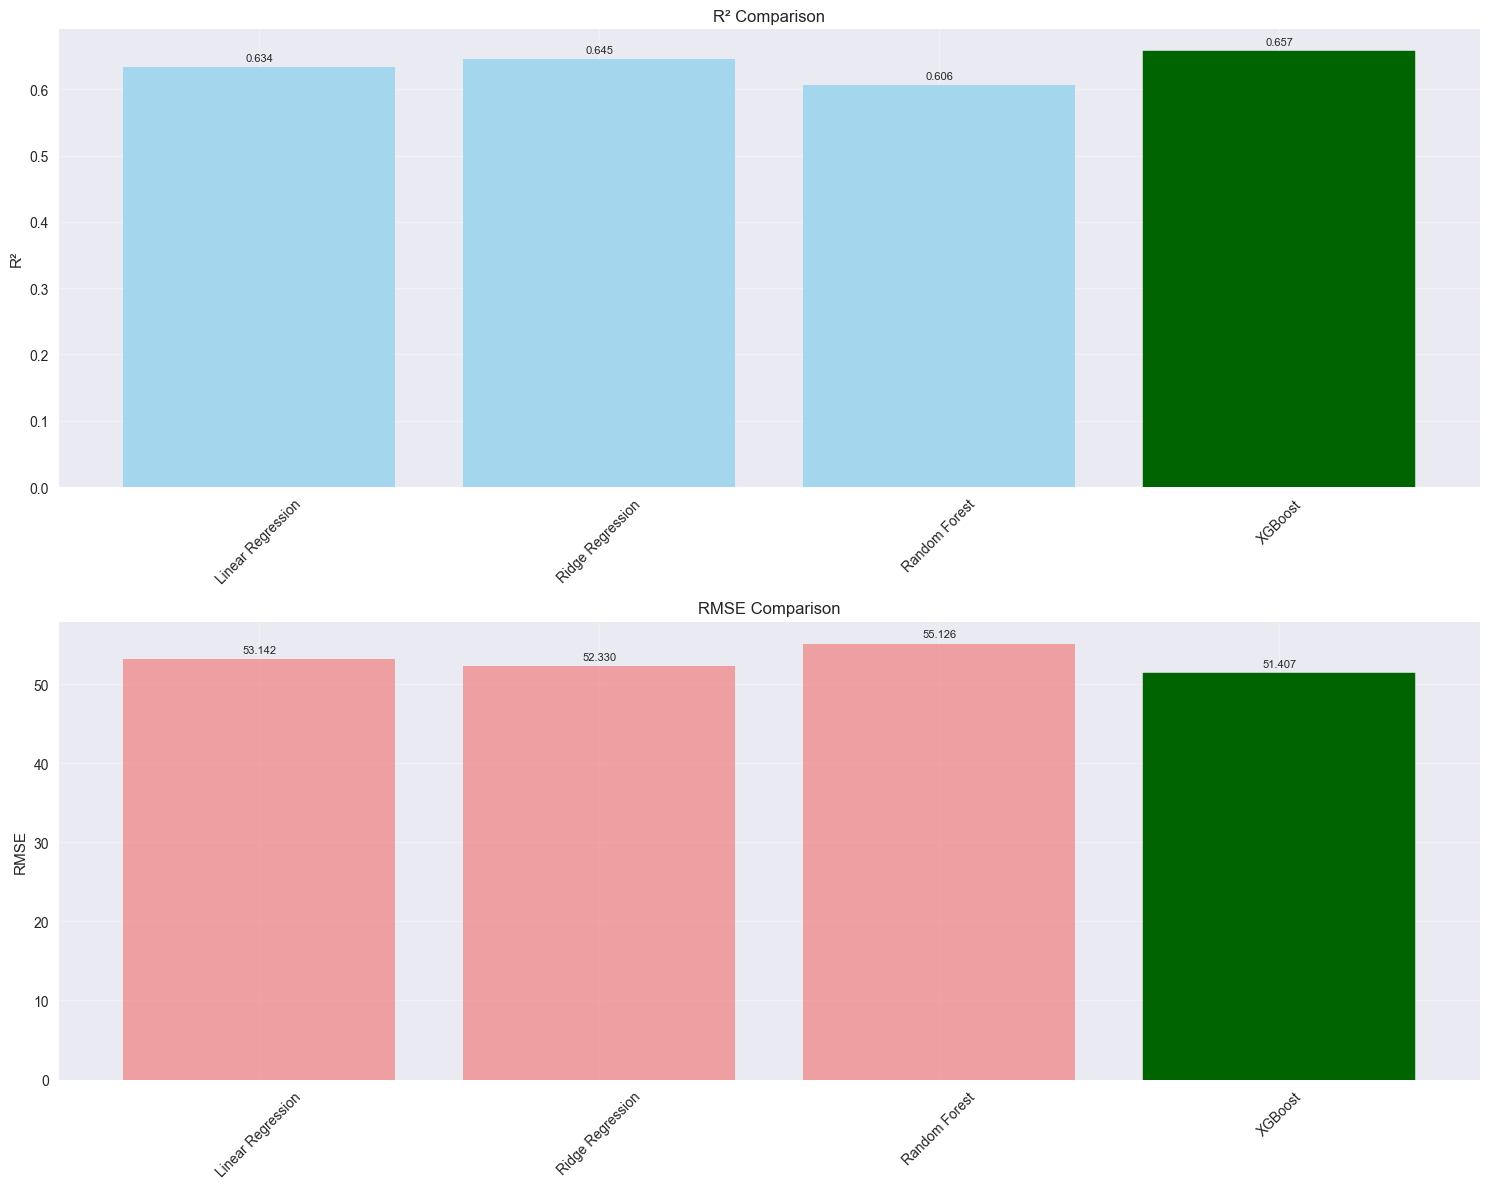

In [14]:
# Visualize model comparison
fig, axes = plt.subplots(2, figsize=(15, 12))
metrics = ['R²', 'RMSE']
colors = ['skyblue', 'lightcoral', 'orange', 'gold']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    values = results_df[metric].values
    models = [name.replace(' (Test)', '') for name in results_df['Model']]
    
    bars = ax.bar(models, values, color=colors[idx], alpha=0.7)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Highlight best performer
    if metric in ['RMSE', 'MAE', 'MAPE_percent']:
        best_idx = np.argmin(values)
    else:
        best_idx = np.argmax(values)
    bars[best_idx].set_color('darkgreen')
    bars[best_idx].set_alpha(1.0)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 8. Deep Learning Architecture Design and Experimentation

This section implements comprehensive deep learning model design including:
- **Architecture Selection**: LSTM, GRU, CNN-LSTM hybrids, 
- **Activation Functions**: ReLU, tanh comparison
- **Optimizers**: Adam, RMSprop

In [15]:
# Deep Learning libraries and setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, regularizers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import itertools

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [16]:
tf.__version__

'2.20.0'

In [17]:
# Prepare data for deep learning
X_train_dl, X_val_dl, y_train_dl, y_val_dl = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True
)

# Convert to numpy arrays for TensorFlow
X_train_array = X_train_dl.values.astype(np.float32)
X_val_array = X_val_dl.values.astype(np.float32)
X_test_array = X_test.values.astype(np.float32)
y_train_array = y_train_dl.values.astype(np.float32)
y_val_array = y_val_dl.values.astype(np.float32)
y_test_array = y_test.values.astype(np.float32)

print("Deep Learning Data Preparation")
print(f"   Training: {X_train_array.shape[0]:,} samples")
print(f"   Validation: {X_val_array.shape[0]:,} samples") 
print(f"   Test: {X_test_array.shape[0]:,} samples")
print(f"   Features: {X_train_array.shape[1]}")



Deep Learning Data Preparation
   Training: 12,537 samples
   Validation: 3,135 samples
   Test: 3,919 samples
   Features: 50


In [18]:
#2 layers perceptron architecture
def simple_mlp(input_dim, activation='relu', optimizer='adam', dropout=0.2):

    model = Sequential([
        layers.Dense(64, activation=activation, input_dim=input_dim),
        layers.Dropout(dropout),
        layers.Dense(32, activation=activation),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [19]:

#deep multi layer perceptron architecture
def deep_mlp(input_dim, activation='relu', optimizer='adam', dropout=0.3, l2_reg=0.001):
    model = Sequential([
        layers.Dense(256, activation=activation, input_dim=input_dim,
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        
        layers.Dense(128, activation=activation,
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        
        layers.Dense(64, activation=activation,
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout/2),
        
        layers.Dense(32, activation=activation),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [20]:
#LSTM architecture

def create_lstm_model(input_shape, activation='relu', optimizer='adam', dropout=0.3, l2_reg=0.001):
    
    model = Sequential([
        layers.LSTM(128, return_sequences=True, input_shape=input_shape,
                   dropout=dropout, recurrent_dropout=dropout/2,
                   kernel_regularizer=regularizers.l2(l2_reg)),
        layers.LSTM(64, dropout=dropout, recurrent_dropout=dropout/2),
        layers.BatchNormalization(),
        layers.Dense(32, activation=activation),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [21]:
#GRU architecture
def create_gru_model(input_shape, activation='relu', optimizer='adam', dropout=0.3, l2_reg=0.001):
    model = Sequential([
        layers.GRU(128, return_sequences=True, input_shape=input_shape,
                  dropout=dropout, recurrent_dropout=dropout/2,
                  kernel_regularizer=regularizers.l2(l2_reg)),
        layers.GRU(64, dropout=dropout, recurrent_dropout=dropout/2),
        layers.BatchNormalization(),
        layers.Dense(32, activation=activation),
        layers.Dropout(dropout/2),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [23]:

# CNN-LSTM architecture
def create_cnn_lstm_hybrid(input_shape, activation='relu', optimizer='adam', dropout=0.3, l2_reg=0.001):
  
    model = Sequential([
        # Reshape for CNN (add channel dimension)
        layers.Reshape(input_shape + (1,), input_shape=input_shape),
        
        # CNN layers for feature extraction
        layers.Conv2D(32, (3, 1), activation=activation, padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        
        layers.Conv2D(64, (3, 1), activation=activation, padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        
        # Reshape back for LSTM (flatten spatial dimensions)
        layers.Reshape((input_shape[0], 64 * input_shape[1])),
        
        # LSTM layers for temporal modeling
        layers.LSTM(100, return_sequences=True, dropout=dropout, 
                   recurrent_dropout=dropout/2),
        layers.LSTM(50, dropout=dropout, recurrent_dropout=dropout/2),
        
        # Dense layers
        layers.BatchNormalization(),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(32, activation=activation),
        layers.Dropout(dropout/2),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


#CNN for the Feature extraction from spatial patterns
#LSTM for the Temporal sequence modeling 


## 11) Activation funciton Comparison 

In [29]:
def test_activation_functions():

    activations = {
        'relu': 'relu',
        'tanh': 'tanh', 
        'leaky_relu': layers.LeakyReLU(alpha=0.01)
        
    }
    
    
    activation_results = []
    
    for name, activation in activations.items():
        
        try:
            if name == 'leaky_relu':
                # Special case for LeakyReLU
                model = Sequential([
                    layers.Dense(128, input_dim=X_train_array.shape[1]),
                    activation,
                    layers.Dropout(0.2),
                    layers.Dense(64),
                    activation,
                    layers.Dropout(0.2), 
                    layers.Dense(1, activation='linear')
                ])
                model.compile(optimizer='adam', loss='mse', metrics=['mae'])
                activation_name = name
            else:
                model = simple_mlp(X_train_array.shape[1], activation=activation)
                activation_name = name
            
            # short training with early stopping
            early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            history = model.fit(
                X_train_array, y_train_array,
                validation_data=(X_val_array, y_val_array),
                epochs=30,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # Evaluate
            y_pred = model.predict(X_test_array, verbose=0).flatten()
            results = evaluate_model(y_test_array, y_pred, f'{activation_name.title()} Activation')
            activation_results.append(results)
            
            print(f"   {activation_name}: R² = {results['R²']:.4f}, RMSE = {results['RMSE']:.2f}")
            
        except Exception as e:
            print(f"    {name} failed: {str(e)}")
    
    return activation_results


In [30]:
optimal_activate_funtion=test_activation_functions()

   relu: R² = 0.5920, RMSE = 56.10
   tanh: R² = 0.5983, RMSE = 55.66
   leaky_relu: R² = 0.5088, RMSE = 61.55


## 12) Optimizer comparison

In [31]:
def test_optimizers():
    optimizers_config = {
        'adam': optimizers.Adam(learning_rate=0.001),
        'rmsprop': optimizers.RMSprop(learning_rate=0.001)
    }
    
    optimizer_results = []
    
    for name, optimizer in optimizers_config.items():

        
        try:
            model = simple_mlp(X_train_array.shape[1], optimizer=optimizer)
            
            early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            
            history = model.fit(
                X_train_array, y_train_array,
                validation_data=(X_val_array, y_val_array),
                epochs=30,
                batch_size=32,
                callbacks=[early_stopping],
                verbose=0
            )
            
            y_pred = model.predict(X_test_array, verbose=0).flatten()
            results = evaluate_model(y_test_array, y_pred, f'{name.upper()} Optimizer')
            optimizer_results.append(results)
            
            print(f"   {name}: R² = {results['R²']:.4f}, RMSE = {results['RMSE']:.2f}")
            
        except Exception as e:
            print(f"   {name} failed: {str(e)}")
    
    return optimizer_results

In [32]:
optimal_optimizer=test_optimizers()

   adam: R² = 0.5337, RMSE = 59.97
   rmsprop: R² = 0.6202, RMSE = 54.13


In [36]:
# INDIVIDUAL ARCHITECTURE TESTING FUNCTIONS


def test_deep_mlp():
    
    try:
        # Create model
        model = deep_mlp(X_train_array.shape[1], optimizer='rmsprop')
        
        # Use flat data for MLP
        X_train_reshaped = X_train_array
        X_val_reshaped = X_val_array
        X_test_reshaped = X_test_array
        
        # Training configuration
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=15, 
            restore_best_weights=True,
            verbose=0
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=0
        )
        
        # Train model
        history = model.fit(
            X_train_reshaped, y_train_array,
            validation_data=(X_val_reshaped, y_val_array),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Make predictions
        y_pred = model.predict(X_test_reshaped, verbose=0).flatten()
        
        # Calculate comprehensive metrics
        results = evaluate_model(y_test_array, y_pred, 'Deep MLP')
        
        # Add architecture-specific info
        results.update({
            'Architecture': 'Deep MLP',
            'Training_epochs': len(history.history['loss']),
            'Parameters': model.count_params()
        })
        
        # Display results
        print(f"completed in {len(history.history['loss'])} epochs")
        print(f" R² = {results['R²']:.4f}, MAE = {results['MAE']:.2f} Wh")
        print(f"Parameters: {model.count_params():,}")
        
        return results, history.history
        
    except Exception as e:
        print(f"Deep MLP Failed: {str(e)}")
        return None, None

   

In [37]:
deep_mlp=test_deep_mlp()

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6229.3926 - mae: 43.3517 - val_loss: 3419.5403 - val_mae: 29.1164 - learning_rate: 0.0010
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6229.3926 - mae: 43.3517 - val_loss: 3419.5403 - val_mae: 29.1164 - learning_rate: 0.0010
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3779.0310 - mae: 32.6445 - val_loss: 3174.5171 - val_mae: 29.1467 - learning_rate: 0.0010
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3779.0310 - mae: 32.6445 - val_loss: 3174.5171 - val_mae: 29.1467 - learning_rate: 0.0010
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3574.6440 - mae: 31.8152 - val_loss: 3058.4653 - val_mae: 28.2612 - learning_rate: 0.0010
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3574.6440 - mae: 31.8152 - val_loss: 3058.4653 - val_mae: 28.2612 - learning_rate: 0.0010
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3402.6687 - mae: 31.0869 - val_lo

In [38]:
def test_gru():
    
    try:
        
        model = create_gru_model((X_train_array.shape[1], 1), optimizer='rmsprop')
        
        # Reshape for sequential models
        X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
        X_val_reshaped = X_val_array.reshape(X_val_array.shape[0], X_val_array.shape[1], 1)
        X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)
        
        # Training configuration
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=15, 
            restore_best_weights=True,
            verbose=0
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=0
        )
        
        # Train model
        history = model.fit(
            X_train_reshaped, y_train_array,
            validation_data=(X_val_reshaped, y_val_array),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Make predictions
        y_pred = model.predict(X_test_reshaped, verbose=0).flatten()
        
        # Calculate comprehensive metrics
        results = evaluate_model(y_test_array, y_pred, 'GRU')
        
        # Add architecture-specific info
        results.update({
            'Architecture': 'GRU',
            'Training_epochs': len(history.history['loss']),
            'Parameters': model.count_params()
        })
        
        # Display results
        print(f"completed in {len(history.history['loss'])} epochs")
        print(f"R² = {results['R²']:.4f}, MAE = {results['MAE']:.2f} Wh")
        print(f"Parameters: {model.count_params():,}")
        
        return results, history.history
        
    except Exception as e:
        print(f"GRU Failed: {str(e)}")
        return None, None



In [39]:
gru=test_gru()

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 13828.6035 - mae: 67.8877 - val_loss: 15533.8848 - val_mae: 66.6638 - learning_rate: 0.0010
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 13828.6035 - mae: 67.8877 - val_loss: 15533.8848 - val_mae: 66.6638 - learning_rate: 0.0010
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 12119.7646 - mae: 61.8879 - val_loss: 10214.7041 - val_mae: 74.8286 - learning_rate: 0.0010
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 12119.7646 - mae: 61.8879 - val_loss: 10214.7041 - val_mae: 74.8286 - learning_rate: 0.0010
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 8278.0215 - mae: 49.0450 - val_loss: 5608.5186 - val_mae: 36.9582 - learning_rate: 0.0010
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 8278.0215 - mae: 49.0450 - val_loss: 5608.5186 - val_mae: 36.9582 - learning_rate: 0.0010
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 6175.5532 -

In [41]:
def test_cnn_lstm():
    try:
        # Create model
        model = create_cnn_lstm_hybrid((X_train_array.shape[1], 1), optimizer='rmsprop')
        
        # Reshape for sequential models
        X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
        X_val_reshaped = X_val_array.reshape(X_val_array.shape[0], X_val_array.shape[1], 1)
        X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1], 1)
        
        # Training configuration
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=15, 
            restore_best_weights=True,
            verbose=0
        )
        
        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=0
        )
        
        # Train model
        history = model.fit(
            X_train_reshaped, y_train_array,
            validation_data=(X_val_reshaped, y_val_array),
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Make predictions
        y_pred = model.predict(X_test_reshaped, verbose=0).flatten()
        
        # Calculate comprehensive metrics
        results = evaluate_model(y_test_array, y_pred, 'CNN-LSTM')
        
        # Add architecture-specific info
        results.update({
            'Architecture': 'CNN-LSTM',
            'Training_epochs': len(history.history['loss']),
            'Parameters': model.count_params()
        })
        
        # Display results
        print(f"Training completed in {len(history.history['loss'])} epochs")
        print(f"R² = {results['R²']:.4f}, MAE = {results['MAE']:.2f} Wh")
        print(f"Parameters: {model.count_params():,}")
        
        return results, history.history
        
    except Exception as e:
        print(f"CNN-LSTM Failed: {str(e)}")
        return None, None



In [42]:
cnn_lstm=test_cnn_lstm()

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 11366.0801 - mae: 59.6624 - val_loss: 7530.3291 - val_mae: 45.0255 - learning_rate: 0.0010
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 11366.0801 - mae: 59.6624 - val_loss: 7530.3291 - val_mae: 45.0255 - learning_rate: 0.0010
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 6492.2500 - mae: 43.5236 - val_loss: 5340.8120 - val_mae: 37.1010 - learning_rate: 0.0010
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 6492.2500 - mae: 43.5236 - val_loss: 5340.8120 - val_mae: 37.1010 - learning_rate: 0.0010
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 5617.3647 - mae: 39.8072 - val_loss: 4861.8892 - val_mae: 34.4693 - learning_rate: 0.0010
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 5617.3647 - mae: 39.8072 - val_loss: 4861.8892 - val_mae: 34.4693 - learning_rate: 0.0010
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 5087.5596 - mae: 

## 5. Model optimization

This section implements comprehensive optimization strategies including:
- Hyperparameter Tuning(Random Search)
- Regularization Techniques(Dropout, L1/L2, Batch Normalization)
- Early Stopping
- Performance Comparison

## 5.1 Hyperparameter Tuning

In [59]:
def create_optimized_model(params, input_shape):
   
    
    model = tf.keras.Sequential([
        tf.keras.layers.Reshape((input_shape[1], 1), input_shape=input_shape),
        
        # CNN Feature Extraction Layers
        tf.keras.layers.Conv1D(
            filters=params['cnn_filters_1'], 
            kernel_size=params['cnn_kernel_size'],
            activation='relu',
            padding='same',  
            kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(params['dropout_rate']),
        
        tf.keras.layers.Conv1D(
            filters=params['cnn_filters_2'],
            kernel_size=params['cnn_kernel_size'],
            activation='relu',
            padding='same',  
            kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(params['dropout_rate']),
        
        # LSTM Temporal Processing Layers
        tf.keras.layers.LSTM(
            units=params['lstm_units_1'],
            return_sequences=True,
            dropout=params['dropout_rate'],
            recurrent_dropout=params['dropout_rate']/2,
            kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])
        ),
        
        tf.keras.layers.LSTM(
            units=params['lstm_units_2'],
            dropout=params['dropout_rate'],
            recurrent_dropout=params['dropout_rate']/2,
            kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])
        ),
        
        # Dense Output Layers
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(
            params['dense_units'],
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(params['l2_reg'])
        ),
        tf.keras.layers.Dropout(params['dropout_rate']),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    
    # Configure optimizer
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mape']
    )
    
    return model

In [63]:
import random
import numpy as np

def random_search_optimization(n_trials=20):
    results = []
    input_shape = (1, 50)
    
    for trial in range(n_trials):
        print(f"\n=== Trial {trial + 1}/{n_trials} ===")
        
        # Randomly sample parameters
        params = {
            'cnn_filters_1': random.choice([16, 32, 64]),
            'cnn_filters_2': random.choice([32, 64, 128]),
            'cnn_kernel_size': random.choice([3, 5,7]),
            'l2_reg': random.choice([0.001, 0.01, 0.1]),
            'dropout_rate': random.choice([0.1, 0.2, 0.3]),
            'lstm_units_1': random.choice([50, 100, 150]),
            'lstm_units_2': random.choice([25, 50, 100]),
            'dense_units': random.choice([32, 64, 128]),
            'optimizer': random.choice(['rmsprop']),
            'learning_rate': random.choice([0.001, 0.01])
        }
        
        print(f"Testing parameters: {params}")
        
        try:
            # Create and train model
            model = create_optimized_model(params, input_shape)
            
            # Early stopping
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', 
                patience=5, 
                restore_best_weights=True
            )
            
            # Reshape data for CNN-LSTM (samples, timesteps, features)
            X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 1, X_train_array.shape[1])
            X_val_reshaped = X_val_array.reshape(X_val_array.shape[0], 1, X_val_array.shape[1])
            
            # Train model
            history = model.fit(
                X_train_reshaped, y_train_array,
                validation_data=(X_val_reshaped, y_val_array),
                epochs=20,  # Reduced for faster search
                batch_size=64,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # Evaluate
            val_predictions = model.predict(X_val_reshaped, verbose=0)
            val_r2 = r2_score(y_val_array, val_predictions)
            val_mae = mean_absolute_error(y_val_array, val_predictions)
            val_rmse = np.sqrt(mean_squared_error(y_val_array, val_predictions))
            
            # Store results
            result = {
                'trial': trial + 1,
                'params': params.copy(),
                'val_r2': val_r2,
                'val_mae': val_mae,
                'val_rmse': val_rmse,
                'epochs_trained': len(history.history['loss'])
            }
            results.append(result)
            
            print(f"R² Score: {val_r2:.4f}")
            print(f"MAE: {val_mae:.2f}")
            print(f"RMSE: {val_rmse:.2f}")
            print(f"Epochs: {len(history.history['loss'])}")
            
        except Exception as e:
            print(f"Trial failed: {str(e)}")
            continue
    
    return results

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
# Run the optimization
print("Starting hyperparameter optimization...")

optimization_results = random_search_optimization(n_trials=5)  # Start with 5 trials

Starting hyperparameter optimization...

=== Trial 1/5 ===
Testing parameters: {'cnn_filters_1': 64, 'cnn_filters_2': 32, 'cnn_kernel_size': 3, 'l2_reg': 0.1, 'dropout_rate': 0.2, 'lstm_units_1': 50, 'lstm_units_2': 25, 'dense_units': 32, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
R² Score: 0.7350
MAE: 26.97
RMSE: 56.34
Epochs: 20

=== Trial 2/5 ===
Testing parameters: {'cnn_filters_1': 64, 'cnn_filters_2': 128, 'cnn_kernel_size': 7, 'l2_reg': 0.01, 'dropout_rate': 0.1, 'lstm_units_1': 100, 'lstm_units_2': 100, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
R² Score: 0.7350
MAE: 26.97
RMSE: 56.34
Epochs: 20

=== Trial 2/5 ===
Testing parameters: {'cnn_filters_1': 64, 'cnn_filters_2': 128, 'cnn_kernel_size': 7, 'l2_reg': 0.01, 'dropout_rate': 0.1, 'lstm_units_1': 100, 'lstm_units_2': 100, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
R² Score: 0.7740
MAE: 26.67
RMSE: 52.03
Epochs: 20

=== Trial 3/5 ===
Testing parameters: {'cnn_filters_1': 3

In [81]:
# Analyze optimization results
if optimization_results:
    # Sort by R² score (descending)
    sorted_results = sorted(optimization_results, key=lambda x: x['val_r2'], reverse=True)
    
    
    for i, result in enumerate(sorted_results[:5]):
        print(f"\n#{i+1} - Trial {result['trial']}")
        print(f"   R² Score: {result['val_r2']:.4f}")
        print(f"   MAE: {result['val_mae']:.2f} Wh")
        print(f"   RMSE: {result['val_rmse']:.2f} Wh")
        print(f"   Epochs: {result['epochs_trained']}")
        print(f"   Parameters: {result['params']}")
    
    # Best parameters
    best_params = sorted_results[0]['params']
    best_score = sorted_results[0]['val_r2']
    
    print(f"\n OPTIMAL PARAMETERS (R² = {best_score:.4f}):")
    print("-" * 50)
    for key, value in best_params.items():
        print(f"   {key}: {value}")
    
    # Save optimal parameters for easy use
    optimal_hyperparameters = best_params.copy()
    
    print(f"\nOptimal parameters saved in 'optimal_hyperparameters' variable")
    print(f"You can now use: model = create_optimized_model(optimal_hyperparameters, (1, 50))")

else:
    print(" No results available. Please run the optimization first.")


#1 - Trial 4
   R² Score: 0.7985
   MAE: 23.77 Wh
   RMSE: 49.13 Wh
   Epochs: 20
   Parameters: {'cnn_filters_1': 64, 'cnn_filters_2': 32, 'cnn_kernel_size': 5, 'l2_reg': 0.001, 'dropout_rate': 0.1, 'lstm_units_1': 50, 'lstm_units_2': 50, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.01}

#2 - Trial 2
   R² Score: 0.7740
   MAE: 26.67 Wh
   RMSE: 52.03 Wh
   Epochs: 20
   Parameters: {'cnn_filters_1': 64, 'cnn_filters_2': 128, 'cnn_kernel_size': 7, 'l2_reg': 0.01, 'dropout_rate': 0.1, 'lstm_units_1': 100, 'lstm_units_2': 100, 'dense_units': 64, 'optimizer': 'rmsprop', 'learning_rate': 0.001}

#3 - Trial 5
   R² Score: 0.7692
   MAE: 25.42 Wh
   RMSE: 52.59 Wh
   Epochs: 20
   Parameters: {'cnn_filters_1': 64, 'cnn_filters_2': 128, 'cnn_kernel_size': 3, 'l2_reg': 0.001, 'dropout_rate': 0.2, 'lstm_units_1': 100, 'lstm_units_2': 50, 'dense_units': 128, 'optimizer': 'rmsprop', 'learning_rate': 0.01}

#4 - Trial 3
   R² Score: 0.7651
   MAE: 25.81 Wh
   RMSE: 53.05 Wh
   E

In [71]:
final_params = {
            'cnn_filters_1':64,
            'cnn_filters_2': 32,
            'cnn_kernel_size': 5,
            'l2_reg': 0.001,
            'dropout_rate': 0.1,
            'lstm_units_1': 50,
            'lstm_units_2': 50,
            'dense_units': 64,
            'optimizer': 'rmsprop',
            'learning_rate': 0.01
        }

# Final Model Training with Optimized Parameters


In [75]:
# Create the final model
final_model = create_optimized_model(final_params, input_shape=(1, 50))

# Prepare data for final training
X_train_final = X_train_array.reshape(X_train_array.shape[0], 1, X_train_array.shape[1])
X_val_final = X_val_array.reshape(X_val_array.shape[0], 1, X_val_array.shape[1]) 
X_test_final = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])

print(f"\nData Shapes:")
print(f"   Training: {X_train_final.shape}")
print(f"   Validation: {X_val_final.shape}")
print(f"   Test: {X_test_final.shape}")


callbacks= [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
     tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )

]

print(f"\n Starting final training...")
start_time = time.time()

# Train the final model
history = final_model.fit(
    X_train_final, y_train_array,
    validation_data=(X_val_final, y_val_array),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n Training completed in {training_time/60:.1f} minutes!")
print(f"   Final training epochs: {len(history.history['loss'])}")
print(f"   Best validation loss: {min(history.history['val_loss']):.4f}")


Data Shapes:
   Training: (12537, 1, 50)
   Validation: (3135, 1, 50)
   Test: (3919, 1, 50)

 Starting final training...
Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 6589.0488 - mae: 42.1994 - mape: 44.5827 - val_loss: 6274.9990 - val_mae: 34.7604 - val_mape: 26.7488 - learning_rate: 0.0100
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 4720.6484 - mae: 34.7123 - mape: 36.3445 - val_loss: 4166.9717 - val_mae: 36.6903 - val_mape: 41.1714 - learning_rate: 0.0100
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 4365.1416 - mae: 33.0534 - mape: 34.6185 - val_loss: 3474.8813 - val_mae: 28.6047 - val_mape: 30.1478 - learning_rate: 0.0100
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 4169.7798 - mae: 32.3167 - mape: 33.9645 - val_loss: 3547.9695 - val_mae: 28.5332 - val_mape: 26.1875 - learning_rate: 0.0100
Epoch 5/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 3901.3391 - mae: 31.6729 - mape: 33.6715 - val_loss: 3513.

In [80]:
train_predictions = final_model.predict(X_train_final, verbose=0).flatten()
val_predictions = final_model.predict(X_val_final, verbose=0).flatten() 
test_predictions = final_model.predict(X_test_final, verbose=0).flatten()

# Calculate comprehensive metrics for all sets
train_results = evaluate_model(y_train_array, train_predictions, 'Final CNN-LSTM (Train)')
val_results = evaluate_model(y_val_array, val_predictions, 'Final CNN-LSTM (Validation)')
test_results = evaluate_model(y_test_array, test_predictions, 'Final CNN-LSTM (Test)')


metrics_to_show = ['R²', 'RMSE', 'MAE', 'MAPE_percent']
for metric in metrics_to_show:
    train_val = train_results[metric]
    val_val = val_results[metric] 
    test_val = test_results[metric]
    print(f"{metric:<15} {train_val:<12.4f} {val_val:<12.4f} {test_val:<12.4f}")

# Overfitting analysis
train_r2 = train_results['R²']
test_r2 = test_results['R²']
overfitting_gap = train_r2 - test_r2

print(f"   Training R²: {train_r2:.4f}")
print(f"   Test R²: {test_r2:.4f}")
print(f"   Overfitting Gap: {overfitting_gap:.4f}")

if overfitting_gap < 0.05:
    print(" Status:good")
elif overfitting_gap < 0.1:
    print("Status: Mild overfitting")
else:
    print("Status:overfitting")

# Compare against baselines

print(f"   Best Baseline R²: {best_r2:.4f} ({best_overall.replace(' (Test)', '')})")
print(f"   Final CNN-LSTM R²: {test_r2:.4f}")
improvement = test_r2 - best_r2
print(f"   Improvement: {improvement:+.4f} R² points")

if improvement > 0:
    print("CNN-LSTM has better performance ") 

R²              0.8236       0.7994       0.7363      
RMSE            44.0344      49.0262      45.0964     
MAE             21.2291      22.5629      20.0246     
MAPE_percent    22.6299      23.5767      18.9042     
   Training R²: 0.8236
   Test R²: 0.7363
   Overfitting Gap: 0.0872
Status: Mild overfitting
   Best Baseline R²: 0.6574 (XGBoost)
   Final CNN-LSTM R²: 0.7363
   Improvement: +0.0789 R² points
CNN-LSTM has better performance 


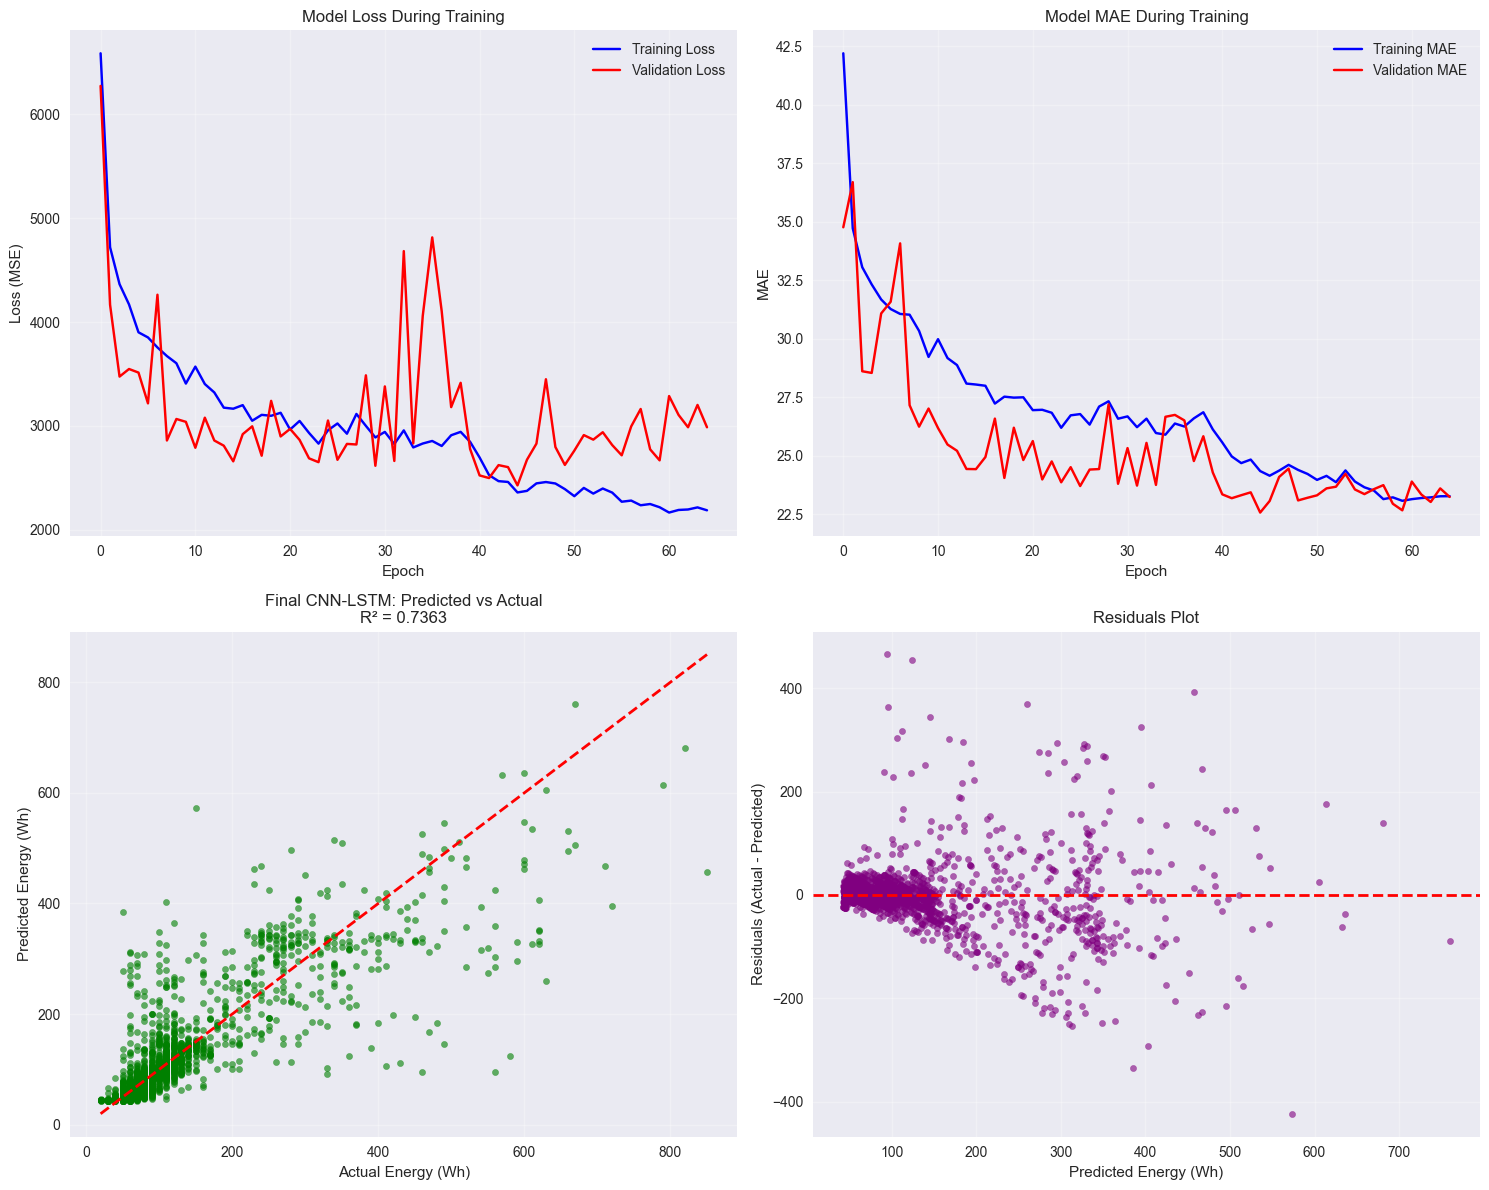

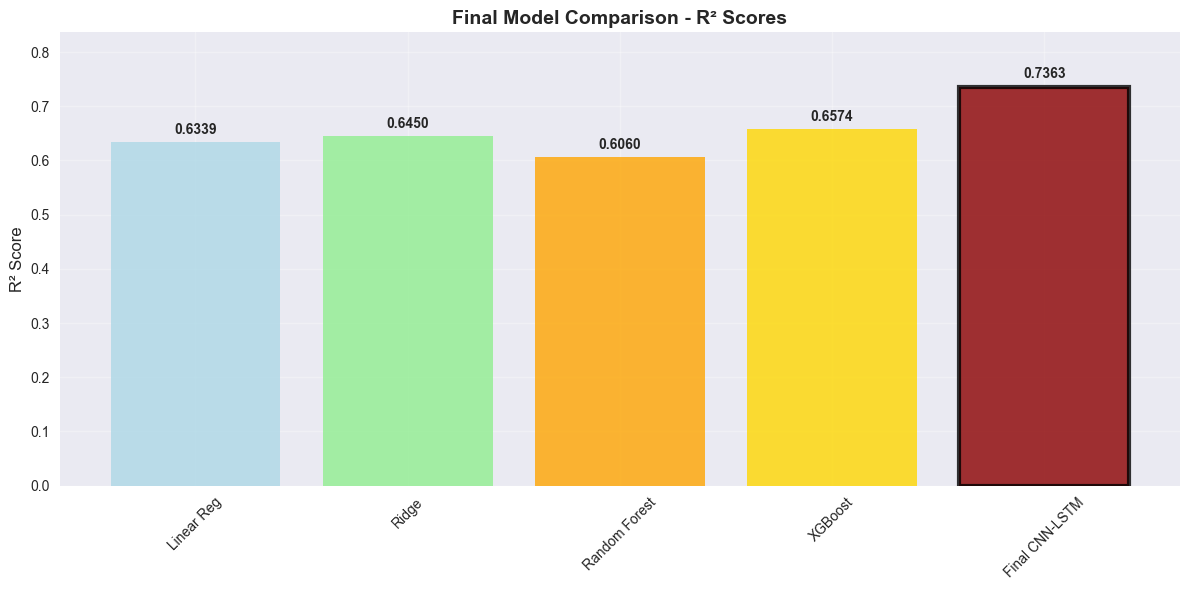

In [77]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Training loss
axes[0,0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0,0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0,0].set_title('Model Loss During Training')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss (MSE)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Training MAE
axes[0,1].plot(history.history['mae'], label='Training MAE', color='blue')
axes[0,1].plot(history.history['val_mae'], label='Validation MAE', color='red')
axes[0,1].set_title('Model MAE During Training')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('MAE')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Predictions vs Actual (Test Set)
axes[1,0].scatter(y_test_array, test_predictions, alpha=0.6, s=20, color='green')
axes[1,0].plot([y_test_array.min(), y_test_array.max()], 
               [y_test_array.min(), y_test_array.max()], 'r--', linewidth=2)
axes[1,0].set_xlabel('Actual Energy (Wh)')
axes[1,0].set_ylabel('Predicted Energy (Wh)')
axes[1,0].set_title(f'Final CNN-LSTM: Predicted vs Actual\nR² = {test_r2:.4f}')
axes[1,0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test_array - test_predictions
axes[1,1].scatter(test_predictions, residuals, alpha=0.6, s=20, color='purple')
axes[1,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Predicted Energy (Wh)')
axes[1,1].set_ylabel('Residuals (Actual - Predicted)')
axes[1,1].set_title('Residuals Plot')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare comparison data
model_names = ['Linear Reg', 'Ridge', 'Random Forest', 'XGBoost', 'Final CNN-LSTM']
r2_scores = [
    lr_test_results['R²'],
    ridge_test_results['R²'], 
    rf_test_results['R²'],
    xgb_test_results['R²'],
    test_r2
]

colors = ['lightblue', 'lightgreen', 'orange', 'gold', 'darkred']
bars = ax.bar(model_names, r2_scores, color=colors, alpha=0.8)

# Highlight the best model
best_idx = r2_scores.index(max(r2_scores))
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(3)

ax.set_title('Final Model Comparison - R² Scores', fontsize=14, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=12)
ax.set_ylim(0, max(r2_scores) + 0.1)
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Model Saving


In [82]:
import os
import pickle
from datetime import datetime

# Create models directory if it doesn't exist
models_dir = '../models'

# Save the trained CNN-LSTM model
model_filename = f'cnn_lstm_energy_model.h5'
model_path = os.path.join(models_dir, model_filename)

# Save the Keras model
final_model.save(model_path)
print(f"Model saved successfully to: {model_path}")

# Save model metadata and performance metrics
metadata = {
    'model_type': 'CNN-LSTM Hybrid',
    'architecture': 'CNN layers followed by LSTM layers',
    'test_r2_score': float(test_r2),
    'test_rmse': float(np.sqrt(np.mean((y_test_array - test_predictions)**2))),
    'test_mae': float(np.mean(np.abs(y_test_array - test_predictions))),
    'training_date': datetime.now().isoformat(),
    'input_shape': X_train_final.shape[1:],
    'features_used': X_train.shape[1],
    'training_samples': X_train_final.shape[0],
    'test_samples': X_test_final.shape[0],
    'epochs_trained': len(history.history['loss']),
    'final_training_loss': float(history.history['loss'][-1]),
    'final_validation_loss': float(history.history['val_loss'][-1])
}

metadata_filename = f'cnn_lstm_metadata.pkl'
metadata_path = os.path.join(models_dir, metadata_filename)

with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
    
print(f"Model metadata saved to: {metadata_path}")



Model saved successfully to: ../models\cnn_lstm_energy_model.h5
Model metadata saved to: ../models\cnn_lstm_metadata.pkl
